In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d

from tqdm import tqdm
import seaborn as sns
import pickle
from scipy import stats
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [125]:
gamma_func_ffp_point = pickle.load(open("interps/gamma_func_ffp_point.p", "rb"))
gamma_func_pbh_point = pickle.load(open("interps/gamma_func_pbh_point.p", "rb"))
gamma_func_ffp = pickle.load(open("interps/gamma_func_ffp_finite.p", "rb"))
gamma_func_pbh = pickle.load(open("interps/gamma_func_pbh_finite.p", "rb"))

gamma_func_pbh_sigma = pickle.load(open("interps/gamma_func_pbh_finite_sigma.p", "rb"))
gamma_func_pbh_finite_sigma_15 = pickle.load(open("interps/gamma_func_pbh_finite_sigma_15.p", "rb"))
gamma_func_pbh_finite_sigma_10 = pickle.load(open("interps/gamma_func_pbh_finite_sigma_10.p", "rb"))
gamma_func_pbh_finite_sigma_05 = pickle.load(open("interps/gamma_func_pbh_finite_sigma_05.p", "rb"))
gamma_func_pbh_finite_sigma_01 = pickle.load(open("interps/gamma_func_pbh_finite_sigma_01.p", "rb"))
gamma_func_pbh_finite_sigma_all = pickle.load(open("interps/gamma_func_pbh_finite_sigma_all.p", "rb"))


In [9]:
roman_df = pd.read_csv('roman_sensitivity.csv', header=None, names=['t_e [days]', 'efficiency'])
roman_efficiency_interp = interp1d(roman_df['t_e [days]'], roman_df['efficiency'])
def roman_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of Roman
    '''
    t_day = t/24
    if t_day <= np.min(roman_df['t_e [days]']):
        return roman_df['efficiency'][0]
    if t_day >= np.max(roman_df['t_e [days]']):
        return roman_df['efficiency'][len(roman_df)-1]
    return(roman_efficiency_interp(t_day))

In [63]:
def sample_crossing_times(t_es, gammas, n_samples, tmin=0, tmax=np.inf):
    norm_gammas = gammas/np.sum(gammas)
    cdf = np.cumsum(norm_gammas)
    
    samples = []
    iterations = 0
    while len(samples) < n_samples:
        iterations += 1
        r = np.random.rand()
        t_e_sample = np.interp(r, cdf, t_es)
        if t_e_sample > tmin and t_e_sample < tmax:
            samples.append(t_e_sample)        
        if iterations > 100*n_samples:
            raise ValueError("Could not sample enough crossing times in 100*n_samples iterations.")
    return np.array(samples)

def sample_t_ffp(p, t_es, gamma_func, n_samples=1000):
    pmin = min(gamma_func.grid[0])
    pmax = max(gamma_func.grid[0])
    tmin = min(gamma_func.grid[1])
    tmax = max(gamma_func.grid[1])
    if p < pmin or p > pmax:
        raise ValueError(f"p = {p} is outside of the range of p values in the interpolating function: {pmin} to {pmax}")
    if min(t_es) < tmin:
        raise ValueError(f"t_e = {min(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    if max(t_es) > tmax:
        raise ValueError(f"t_e = {max(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    
    gammas = np.array([gamma_func([[p, t]]) * roman_efficiency(t) for t in t_es])

    samples = sample_crossing_times(t_es, gammas, n_samples, tmin=0.25, tmax=43800)
    return samples

def sample_t_pbh(m, t_es, gamma_func, n_samples=1000):
    mmin = min(gamma_func.grid[0])
    mmax = max(gamma_func.grid[0])
    tmin = min(gamma_func.grid[1])
    tmax = max(gamma_func.grid[1])
    if m < mmin or m > mmax:
        print(f"m = {m} is outside of the range of m values in the interpolating function: {mmin} to {mmax}")
    if min(t_es) < tmin:
        raise ValueError(f"t_e = {min(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    if max(t_es) > tmax:
        raise ValueError(f"t_e = {max(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    
    gammas = np.array([gamma_func([[m, t]]) * roman_efficiency(t) for t in t_es])

    samples = sample_crossing_times(t_es, gammas, n_samples, tmin=0.25, tmax=43800)
    return samples

def sample_t_pbh_sigma(m, t_es, gamma_func, sigma, n_samples=1000):
    mmin = 10**min(gamma_func.grid[0])
    mmax = 10**max(gamma_func.grid[0])
    sigma_min = 10**min(gamma_func.grid[1])
    sigma_max = 10**max(gamma_func.grid[1])
    tmin = 10**min(gamma_func.grid[2])
    tmax = 10**max(gamma_func.grid[2])
    if m < mmin or m > mmax:
        print(f"m = {m} is outside of the range of m values in the interpolating function: {mmin} to {mmax}")
    if min(t_es) < tmin:
        raise ValueError(f"t_e = {min(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    if max(t_es) > tmax:
        raise ValueError(f"t_e = {max(t_es)} is outside of the range of t values in the interpolating function: {tmin} to {tmax}")
    if sigma < sigma_min or sigma > sigma_max:
        print(f"sigma = {sigma} is outside of the range of sigma values in the interpolating function: {sigma_min} to {sigma_max}")
    
    gammas = np.array([10**(gamma_func([[np.log10(m), np.log10(sigma), np.log10(t)]])) * roman_efficiency(t) for t in t_es])

    samples = sample_crossing_times(t_es, gammas, n_samples, tmin=0.25, tmax=43800)
    return samples
    

In [64]:
print(np.min(gamma_func_ffp.grid[1]))
print(np.max(gamma_func_ffp.grid[1]))

0.012589254117941675
50118.72336272725


In [113]:
p_arr = np.linspace(0.66, 1.33, 4)
# m_arr = np.logspace(-10, 1, 8)

# p_arr = [0.66]
m_arr = [1e-7]

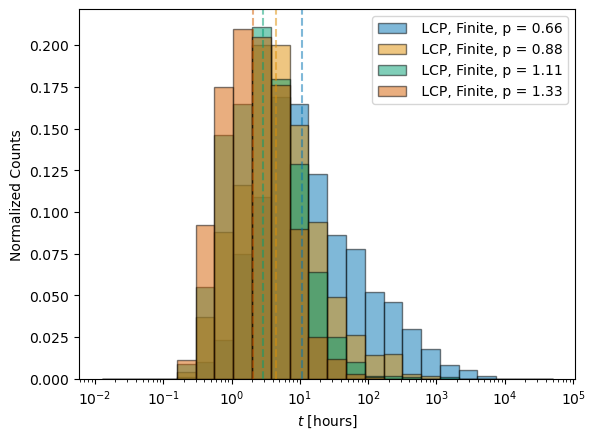

In [66]:
# ts_sample = np.logspace(-1.5, 4.4, 100)
# bins = np.logspace(-1.5, 4.4, 20)
to_min = np.min(gamma_func_ffp.grid[1])
to_max = np.max(gamma_func_ffp.grid[1])
ts_sample = np.logspace(np.log10(to_min), np.log10(to_max), 100)
bins = np.logspace(np.log10(to_min), np.log10(to_max), 25)
colors = sns.color_palette("colorblind", len(p_arr))
for i, p in enumerate(p_arr):
    sampled_t_es = sample_t_ffp(p, ts_sample, gamma_func_ffp, n_samples=1000)

    bin_counts, bin_edges = np.histogram(sampled_t_es, bins=bins)
    color = colors[i]
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, p = {round(p,2)}', alpha=0.5, color=color)
    plt.axvline(np.median(sampled_t_es), linestyle="--", alpha=0.5, color=color)
plt.xscale("log")

plt.xlabel(r'$t$ [hours]')
plt.ylabel(r'Normalized Counts')

plt.legend()
plt.show()

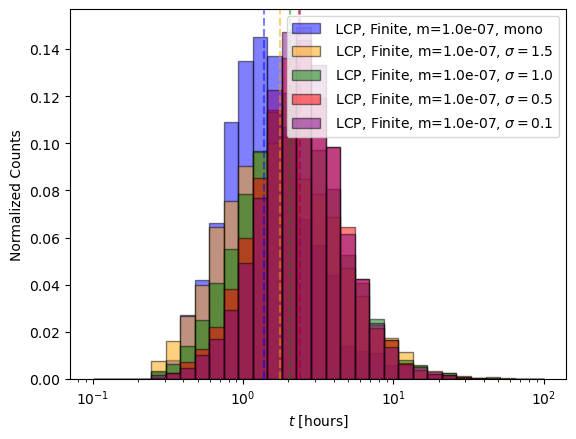

In [127]:
# ts_sample = np.logspace(-1.5, 4.5, 100)
# bins = np.logspace(-1.5, 4.5, 24)
to_min = np.min(gamma_func_pbh.grid[1])
to_max = np.max(gamma_func_pbh.grid[1])
ts_sample = np.logspace(np.log10(to_min), np.log10(to_max), 100)
# bins = np.logspace(np.log10(to_min), np.log10(to_max), 25)
bins = np.logspace(np.log10(1e-1), np.log10(1e2), 32)

colors = sns.color_palette("colorblind", len(m_arr))
for i, m in enumerate(m_arr):
    sampled_t_es = sample_t_pbh(m, ts_sample, gamma_func_pbh, n_samples=1000)
    # sampled_t_es_sigma = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_sigma, 0.1, n_samples=10000)
    # sampled_t_es_sigma_15 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_15, 1.5, n_samples=10000)
    # sampled_t_es_sigma_10 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_10, 1.0, n_samples=10000)
    # sampled_t_es_sigma_05 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_05, 0.5, n_samples=10000)
    # sampled_t_es_sigma_01 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_01, 0.1, n_samples=10000)
    sampled_t_es_sigma_15 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_all, 1.5, n_samples=10000)
    sampled_t_es_sigma_10 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_all, 1.0, n_samples=10000)
    sampled_t_es_sigma_05 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_all, 0.5, n_samples=10000)
    sampled_t_es_sigma_01 = sample_t_pbh_sigma(m, ts_sample, gamma_func_pbh_finite_sigma_all, 0.1, n_samples=10000)


    bin_counts, bin_edges = np.histogram(sampled_t_es, bins=bins)
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, m={m:.1e}, mono', alpha=0.5, color='blue')
    plt.axvline(np.median(sampled_t_es), linestyle="--", alpha=0.5, color='blue')

    bin_counts, bin_edges = np.histogram(sampled_t_es_sigma_15, bins=bins)
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, m={m:.1e}, $\sigma=1.5$', alpha=0.5, color='orange')
    plt.axvline(np.median(sampled_t_es_sigma_15), linestyle="--", alpha=0.5, color='orange')

    bin_counts, bin_edges = np.histogram(sampled_t_es_sigma_10, bins=bins)
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, m={m:.1e}, $\sigma=1.0$', alpha=0.5, color='green')
    plt.axvline(np.median(sampled_t_es_sigma_10), linestyle="--", alpha=0.5, color='green')

    bin_counts, bin_edges = np.histogram(sampled_t_es_sigma_05, bins=bins)
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, m={m:.1e}, $\sigma=0.5$', alpha=0.5, color='red')
    plt.axvline(np.median(sampled_t_es_sigma_05), linestyle="--", alpha=0.5, color='red')

    bin_counts, bin_edges = np.histogram(sampled_t_es_sigma_01, bins=bins)
    bars = plt.bar(bin_edges[:-1], bin_counts/np.sum(bin_counts), width=np.diff(bin_edges), align="edge", edgecolor="black", label=f' LCP, Finite, m={m:.1e}, $\sigma=0.1$', alpha=0.5, color='purple')
    plt.axvline(np.median(sampled_t_es_sigma_01), linestyle="--", alpha=0.5, color='purple')
plt.xscale("log")

plt.xlabel(r'$t$ [hours]')
plt.ylabel(r'Normalized Counts')

plt.legend()
plt.show()

## Stats

In [1]:
def my_cdf(sample, x):
        # Counts how many observations are below or equal to x and normalize
        return np.sum(sample <= x) / len(sample)

In [2]:
def ks_2samp(sample1, sample2):
     # Gets all unique observations
    observations = np.unique(np.concatenate((sample1, sample2)))
    
    # Computes the CDF for both samples at each observation
    cdf_sample1 = np.array([my_cdf(sample1, x) for x in observations])
    cdf_sample2 = np.array([my_cdf(sample2, x) for x in observations])

    # Computes the KS statistic
    D_ks = np.max(np.abs(cdf_sample1 - cdf_sample2))

    # Calculates the P-Value based on the two-sided test
    m, n = float(len(sample1)), float(len(sample2))
    #Should this just be m or n if they're the same length?
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(D_ks, np.round(en))
#     print(D_ks, np.sqrt((m + n)/(m * n))*1.36)
    # p_value = stats.kstwo.sf(D_ks, np.round(np.sqrt(en)))

    return {"ks_stat": D_ks, "p_value" : p_value}

In [77]:
def run_scan(p_values, m_values, t_es, n_samples=1000):
    results = []

    for p in p_values:
        for m in m_values:
            # Generate samples for the current p and m values
            samples_ffp = sample_t_ffp(p, t_es, gamma_func_ffp, n_samples)
            samples_pbh = sample_t_pbh(m, t_es, gamma_func_pbh, 250)
            samples_both = np.concatenate((samples_pbh, samples_ffp))
            ks_result = ks_2samp(samples_ffp, samples_both)

            # Store the results
            results.append({
                "p": p,
                "m": m,
                "ks_stat": ks_result["ks_stat"],
                "p_value": ks_result["p_value"]
            })

    return results

In [78]:
# Define the range of p and m values to scan
p_values = np.linspace(0.66, 1.33, 15)  # replace with actual values
m_values = np.logspace(-12, 1, 15)  # replace with actual values
t_es = np.logspace(-2.9, 2.3, 100)

# Run the scan
results = run_scan(p_values, m_values, t_es)

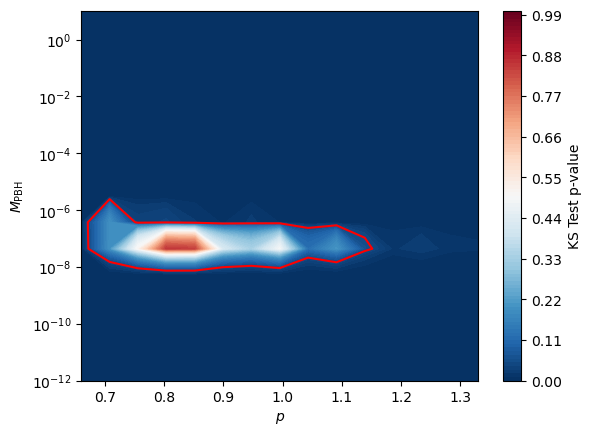

In [80]:
# Convert the list of dictionaries to a list of tuples
results_list_of_tuples = [(d['p'], d['m'], d['ks_stat'], d['p_value']) for d in results]

# Convert the list of tuples to a structured numpy array
results_np = np.array(results_list_of_tuples, dtype=[('p', 'f8'), ('m', 'f8'), ('ks_stat', 'f8'), ('p_value', 'f8')])

# Get unique p and m values
p_values_unique = np.unique(results_np['p'])
m_values_unique = np.unique(results_np['m'])

# Create grids for p and m values
p_grid, m_grid = np.meshgrid(p_values_unique, m_values_unique)

# Create grids for the ks_stat and p_value values
ks_stat_grid = np.array([results_np['ks_stat'][(results_np['p'] == p) & (results_np['m'] == m)][0] for p in p_values_unique for m in m_values_unique]).reshape(len(p_values_unique), len(m_values_unique))
p_value_grid = np.array([results_np['p_value'][(results_np['p'] == p) & (results_np['m'] == m)][0] for p in p_values_unique for m in m_values_unique]).reshape(len(p_values_unique), len(m_values_unique))

# Create the exclusion plot
plt.figure()
cp = plt.contourf(p_grid, m_grid, p_value_grid.T, levels=np.linspace(0, 1, 101), cmap='RdBu_r')
plt.contour(p_grid, m_grid, p_value_grid.T, levels=[0.05], colors='red')


plt.colorbar(cp, label='KS Test p-value')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel(r'$p$')
plt.ylabel(r'$M_{\rm{PBH}}$')
plt.show()

In [137]:
def run_scan(p_values, m_values, n_pbh_values, t_es, n_samples=1000):
    results = []

    for p in p_values:
        for m in m_values:
            for n_pbh in n_pbh_values:
                # Calculate the number of PBH samples based on f_pbh
                n_samples_pbh = int(n_pbh)
                n_samples_ffp = n_samples 

                # Generate samples for the current p, m, and f_pbh values
                samples_ffp = sample_t_ffp(p, t_es, gamma_func_ffp, n_samples_ffp)
                samples_pbh = sample_t_pbh(m, t_es, gamma_func_pbh, n_samples_pbh)
                samples_both = np.concatenate((samples_pbh, samples_ffp))
                ks_result = ks_2samp(samples_ffp, samples_both)

                # Store the results
                results.append({
                    "p": p,
                    "m": m,
                    "n_pbh": n_pbh,
                    "ks_stat": ks_result["ks_stat"],
                    "p_value": ks_result["p_value"]
                })

    return results


In [138]:
p_values = np.linspace(0.66, 1.33, 3)  # replace with actual values
m_values = np.logspace(-10, 1, 5)  # replace with actual values
n_pbh_values = np.logspace(0, 3, 10)
results = run_scan(p_values, m_values, n_pbh_values, t_es)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_43953/1153005848.py:19: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(m_grid, f_pbh_grid, p_value_grid.T, levels=[0.05], label=f'p = {round(p,2)}')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


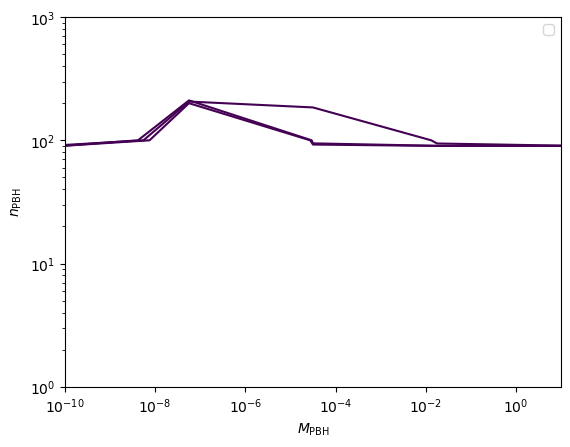

In [140]:
# Get unique p values
results_list_of_tuples = [(d['p'], d['m'], d['n_pbh'], d['ks_stat'], d['p_value']) for d in results]
results_np = np.array(results_list_of_tuples, dtype=[('p', 'f8'), ('m', 'f8'), ('n_pbh', 'f8'), ('ks_stat', 'f8'), ('p_value', 'f8')])
p_values_unique = np.unique(results_np['p'])

# Create separate exclusion plots for each p value
colors = sns.color_palette("colorblind", len(p_values_unique))
for i, p in enumerate(p_values_unique):
    # Filter results for the current p value
    results_filtered = results_np[results_np['p'] == p]

    # Create grids for m and f_pbh values
    m_grid, f_pbh_grid = np.meshgrid(np.unique(results_filtered['m']), np.unique(results_filtered['n_pbh']))

    # Create a grid for the p_value values
    p_value_grid = np.array([results_filtered['p_value'][(results_filtered['m'] == m) & (results_filtered['n_pbh'] == f_pbh)][0] for m in np.unique(results_filtered['m']) for f_pbh in np.unique(results_filtered['n_pbh'])]).reshape(len(np.unique(results_filtered['m'])), len(np.unique(results_filtered['n_pbh'])))

    # Create the exclusion plot
    plt.contour(m_grid, f_pbh_grid, p_value_grid.T, levels=[0.05], label=f'p = {round(p,2)}')

plt.colorbar(cp, label='KS Test p-value')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$M_{\rm{PBH}}$')
plt.ylabel(r'$n_{\rm{PBH}}$')
plt.legend()

plt.show()


In [127]:
results_np

array([(0.66 , 1.00000000e-10, 0.01      , 0.0099596 , 9.99999999e-01),
       (0.66 , 1.00000000e-10, 0.03162278, 0.03042415, 7.40662526e-01),
       (0.66 , 1.00000000e-10, 0.1       , 0.09611111, 2.91042685e-04),
       (0.66 , 1.00000000e-10, 0.31622777, 0.30584211, 3.31340144e-34),
       (0.66 , 1.00000000e-10, 1.        ,        nan,            nan),
       (0.66 , 5.62341325e-08, 0.01      , 0.00427273, 1.00000000e+00),
       (0.66 , 5.62341325e-08, 0.03162278, 0.01282043, 9.99995777e-01),
       (0.66 , 5.62341325e-08, 0.1       , 0.04133333, 3.82509668e-01),
       (0.66 , 5.62341325e-08, 0.31622777, 0.12335673, 7.64946636e-06),
       (0.66 , 5.62341325e-08, 1.        ,        nan,            nan),
       (0.66 , 3.16227766e-05, 0.01      , 0.00662626, 1.00000000e+00),
       (0.66 , 3.16227766e-05, 0.03162278, 0.01829928, 9.95603033e-01),
       (0.66 , 3.16227766e-05, 0.1       , 0.05066667, 1.69463272e-01),
       (0.66 , 3.16227766e-05, 0.31622777, 0.15247953, 1.0451406